In [2]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity

using StatsBase
using Statistics
using Plots
using DataFrames
using SparseArrays
using Clustering

 Activating environment at `~/hypergraph_modularities_code/Project.toml`
┌ Info: Precompiling HypergraphModularity [0c934d27-dd44-49d7-950f-bd4be7819e54]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphModularity does not have DelimitedFiles in its dependencies:
│ - If you have HypergraphModularity checked out for development and have
│   added DelimitedFiles as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphModularity
└ Loading DelimitedFiles into HypergraphModularity from project dependency, future warnings for HypergraphModularity are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [26]:
sum(H.D .>= 5)

2803

In [183]:
# dataset = "HR-congress-bills"
dataset = "TrivagoClickout-cities"
kmax_ = 10

H, Z = read_hypergraph_data(dataset,kmax_)

H, Z = kcore(H, Z, 10)

kmax = maximum(keys(H.E))
α = zeros(2*kmax);

D = big(sum(H.D))
n = length(H.D)

1312

## Acquire Warmstart

In [184]:
D = big(sum(H.D))

ωᵢ = 2.0
ωₒ = 0.6
function ω(p, α)
    num = p[1] == 1 ? ωᵢ : ωₒ
    denom = D^sum(p[2])
    return 10000*num / denom
end

Ω̂ = allOrNothingIntensityFunction(ω, maximum(keys(H.E)));

Ẑ_w = SuperNode_PPLouvain(H, Ω̂; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n);

println(length(unique(Ẑ_w)))

22


In [185]:
randindex(Ẑ_w, Z)[1]

0.7533741702605317

## Dyadic

In [186]:
function projectedGraph(H)
    
    n = length(H.D)
    A = CliqueExpansion(H, false, false)
    ix, jx, w = findnz(A)
    E = Dict(sort([ix[k], jx[k]]) => w[k] for k in 1:length(ix))

    H̄ = hypergraph(collect(1:n), Dict(1 => Dict(), 2 => E), [0])
    HypergraphModularity.computeDegrees!(H̄);
    return H̄
end

H̄ = projectedGraph(H)

Ω̄ = estimateΩEmpirically(H̄, Ẑ_w; aggregator = p -> [length(p) == 1, sum(p)])

DF = DataFrame()

for i ∈ 1:20
    Ẑ, t = @timed SuperNode_PPLouvain(H̄, Ω̄; α = 0, verbose = false)
    Ω̄ = estimateΩEmpirically(H̄, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
    
    Q = modularity(H̄, Ẑ, Ω̄; α = 0)
    ℓ = length(unique(Ẑ))
    ARI = randindex(Z, Ẑ)[1]
    
    df = DataFrame(Q = Q, ℓ = ℓ, ARI = ARI, method = "dyadic")
    DF = vcat(DF, df)
    
    println(rpad(round(Q), 15, " "), "    ", rpad(ℓ, 10, " "), "    ", rpad(t, 10, " ") ,"   ", ARI)
end

-331211.0          32            0.118515937   0.894039018699798
-331199.0          33            0.112269524   0.8989648075153214
-331199.0          33            0.109504682   0.8989648075153214
-331199.0          33            0.112030758   0.8989648075153214
-331199.0          33            0.111178886   0.8989648075153214
-331199.0          33            0.096150877   0.8989648075153214
-331199.0          33            0.098410855   0.8989648075153214
-331199.0          33            0.094331914   0.8989648075153214
-331199.0          33            0.111218981   0.8989648075153214
-331199.0          33            0.104086393   0.8989648075153214
-331199.0          33            0.109134862   0.8989648075153214
-331199.0          33            0.116105323   0.8989648075153214
-331199.0          33            0.112629474   0.8989648075153214
-331199.0          33            0.108496479   0.8989648075153214
-331550.0          33            0.108528616   0.9022959983334262
-331199.0  

# Polyadic AON

In [187]:
Ω̂ = estimateΩEmpirically(H, Ẑ_w; aggregator = p -> [length(p) == 1, sum(p)])

for i ∈ 1:20
    Ẑ, t = @timed SuperNode_PPLouvain(H, Ω̂; α = 0, verbose = false)
    Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
    
    Q = modularity(H, Ẑ, Ω̂; α = 0)
    ℓ = length(unique(Ẑ))
    ARI = randindex(Z, Ẑ)[1]
    
    df = DataFrame(Q = Q, ℓ = ℓ, ARI = ARI, method = "polyadic AON")
    DF = vcat(DF, df)
    
    println(rpad(round(Q), 15, " "), "    ", rpad(ℓ, 10, " "), "    ", rpad(t, 15, " ") ,"   ", ARI)
end

-228875.0          29            0.110950586       0.8480955863599731
-228757.0          30            0.122150676       0.8736675409487955
-228757.0          30            0.121751586       0.8736675409487955
-228930.0          28            0.126444974       0.8545016998702725
-228757.0          30            0.118154419       0.8736675409487955
-228797.0          29            0.105301195       0.8570631848849021
-228757.0          30            0.100123879       0.8736675409487955
-228757.0          30            0.100607859       0.8736675409487955
-228757.0          30            0.099110315       0.8736675409487955
-228757.0          30            0.102556773       0.8736675409487955
-228757.0          30            0.115009814       0.8736675409487955
-228757.0          30            0.122198307       0.8736675409487955
-228757.0          30            0.125641113       0.8736675409487955
-228757.0          30            0.126471526       0.8736675409487955
-228757.0          3

In [188]:
using RCall

R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


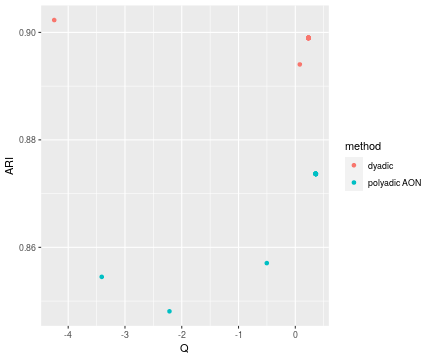

RObject{VecSxp}


In [189]:
R"""
df <- tibble($DF)

df %>% 
    group_by(method) %>% 
    mutate(Q = (Q - mean(Q))/sd(Q)) %>% 
    ggplot() + 
    aes(x = Q, y = ARI, color = method) + 
    geom_point()
"""

# Polyadic General

In [192]:
n_ = big(n)

function ω(p, α)
    k = sum(p)
    return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
end

function ω_m(p, α)
    k = sum(p)
    kmax = length(α) ÷ 2
    return (2*p[1]/k)^α[k] / n_^(α[kmax+k]*k)
end

Ω̂ = partitionIntensityFunction(ω, kmax);
α̂ = vcat(repeat([10.0], kmax), repeat([2.0], kmax));

Ω̂ = partitionIntensityFunction(ω_m, kmax);
α̂ = repeat([2.0], 2*kmax)

α̂ = learnParameters(H, Ẑ_w, Ω̂, α̂; max_iters = 50, verbose = false, tol = 1e-4);
Q = modularity(H, Ẑ_w, Ω̂; α = α̂)

-230297.0261248540458129659704453864105687659986927479508619817187225847533067793

In [193]:
for i ∈ 1:20
    Ẑ, t = @timed SuperNodeLouvain(H, Ω̂; α = α̂, verbose = false, scan_order ="random")
    α̂ = learnParameters(H, Ẑ_w, Ω̂, α̂; max_iters = 10, verbose = false, tol = 1e-4)
    
    Q = modularity(H, Ẑ, Ω̂; α = α̂)
    ℓ = length(unique(Ẑ))
    ARI = randindex(Z, Ẑ)[1]
    
    df = DataFrame(Q = Q, ℓ = ℓ, ARI = ARI, method = "polyadic parameterized")
    DF = vcat(DF, df)
    
    println(rpad(round(Q), 15, " "), "    ", rpad(ℓ, 10, " "), "    ", rpad(t, 15, " ") ,"   ", ARI)
end

-228999.0          30            66.275824452      0.8861159131788843
-229087.0          29            62.389663241      0.8570631848849021
-228949.0          29            69.452134304      0.8711357722801711


InterruptException: InterruptException:

In [285]:
α̂

20-element Array{Float64,1}:
   10.0
    2.0157982450483853
    1.6420402851796
    1.6138989601861196
    1.7548670019352406
    1.511821667189462
    2.129641207389855
    2.4029876852808525
    2.3222944392261917
    2.8310088045893673
 4820.629479614956
    1.2837950944091958
    1.4915557529450094
    1.6133866008600193
    1.6921080904869437
    1.7416951966212864
    1.7751036937749376
    1.7998251081046557
    1.8189623636424275
    1.8356222970012483

In [83]:
for i in 1:10
    Ẑ, t = @timed SuperNode_PPLouvain(H, Ω̂; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
    Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
    Q = modularity(H, Ẑ, Ω̂; α = nothing)
    k = length(unique(Ẑ))
    NMI = mutualInformation(Z, Ẑ, true)
    println(round(Q), "    ", k, "    ", rpad(t, 10, " ") ,"   ", NMI)
end

-24338.0    24    0.097109231   0.02819413075234297
-24373.0    16    0.113282001   0.045375983355760936
-24373.0    15    0.08260662   0.03588840601133854
-24397.0    13    0.137715602   0.020303231136368283
-24413.0    11    0.165952214   0.008474838549360878
-24428.0    10    0.143249124   0.01744823081678586
-24434.0    9    0.095822992   0.024422931187532915
-24485.0    7    0.156647942   0.00782719433531464
-24528.0    5    0.120425984   0.01694186439356128
-24536.0    5    0.089718067   0.006701657752530066


### Majorization Penalty

In [397]:
# warmstart
ωᵢ = 2.0
ωₒ = 0.6
function ω(p, α)
    num = p[1] == 1 ? ωᵢ : ωₒ
    denom = big(sum(H_.D))^sum(p[2])
    return 10000*num / denom
end

Ω = allOrNothingIntensityFunction(ω, maximum(keys(H_.E)));

Ẑ, t = @timed SuperNode_PPLouvain(H, Ω; α = 0, verbose = false, Z0 = collect(1:n), clusterpenalty = n)
Ω̂ = estimateΩEmpirically(H, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
Q = modularity(H, Ẑ, Ω̂; α = nothing) - n*log(length(unique(Z)))
k = length(unique(Ẑ))
println(round(Q - n * log(k)), "    ", k, "    ", t)

-14936.0    6    0.12556582


In [398]:
function ω_m(p, α)
    k = big(sum(p))
    kmax = length(α) ÷ 2
    return (p[1]/k)^α[k] / n^(α[kmax+k]*k)
end

Ω̂ = partitionIntensityFunction(ω_m, kmax);
α̂ = vcat(repeat([10.0], kmax), repeat([1.0], kmax));

In [399]:
for i ∈ 1:5
    α̂ = learnParameters(H, Ẑ, Ω̂, α̂; max_iters = 50, verbose = false) 
    Ẑ, t = @timed SuperNodeLouvain(H,kmax,Ω̂;α=α̂, verbose=false, scan_order ="random");
    Q = modularity(H, Ẑ, Ω̂; α = α̂)
    k = length(unique(Ẑ))
    
    NMI = mutualInformation(Z, Ẑ, true)
    println(round(Q), "    ", k, "    ", rpad(t, 10, " ") ,"   ", NMI)
end

InterruptException: InterruptException:

# Ground Truth

In [416]:
α̂ = learnParameters(H, Z, Ω̂, α̂; max_iters = 1000, verbose = false) 
Q = modularity(H, Z, Ω̂; α = α̂)

-14653.99064269901118557493380289218514767396291651551455769549583275286063969922